# Exploration of Spam in the Enron Email Dataset

The overall goal of this project is the classify messages as spam or not spam, but I also utilize other methods to explore the relationships in the data which are not necessarily spam classification methods.<br/><br/>
I use data acquired from: https://www2.aueb.gr/users/ion/data/enron-spam/ 
<br/><br/>
It contains emails from the enron fraud trail, labelled as spam, or not spam for research purposes. I run on emails from 2 users sent and received over three years.
<br/><br/>
I would like to incorporate all users availabe (6) to reduce bias created by any individual inbox, however due to processing restrictions I needed to limit myself to approximately 10,000 entries.

## 1.Data Preprocessing and Preliminary Analysis
In this section I explore decriptive features of the data, process it, then perform some comparative analysis to inform modelling.

Before I begin applying classification methods, I first load the data into a dataframe with a categorical label for spam. <br/><br/>
The code below iterates overall the data in the folder enron1 and does not load files which are not utf-8 compatible, it is possible these files can be recovered, but with the amount of data available it is not necessary.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn')
import nltk

In [2]:
#Loading the data
path_non_spam = './labelled_dataset/ham/*'
path_spam = './labelled_dataset/spam/*'
import glob
def text_to_pandas(path_1,label):
    l = []
    for filename in glob.glob(path_1):
        try:
            l.append(pd.read_csv(filename, sep ='\t\t\t\t,,,',engine='python'))
        except:
            pass
    df = pd.concat(l, axis=0)
    ham=list()
    for i,file in enumerate(glob.glob(path_1)):
        try:
            with open(file) as f:
                lines = f.readlines()
                ham.append(' '.join(lines))
        except:
            pass
    df=pd.DataFrame.from_dict({'text':ham,'label':[label]*len(ham)})
    return df

df_non_spam=text_to_pandas(path_non_spam,0)
df_spam=text_to_pandas(path_spam,1)
df=pd.concat([df_non_spam,df_spam])
df = df.reset_index().drop(['index'],axis = 1)
df.head()

,text,label
0,Subject: ena sales on hpl\n just to update you...,0
1,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...,0
2,Subject: re : telephone interview with enron c...,0
3,"Subject: hpl nominations for december 28 , 199...",0
4,"Subject: revised nom - kcs resources\n daren ,...",0


### 1.1 Analysis of the dataset
To better understand the dataset, I explore the portion of spam to non-spam (hereafter ham), length, and comparative word frequency.

       text                                                               
      count unique                                                top freq
label                                                                     
0      8032   7839  Subject: calpine daily gas nomination\n >\n ri...   20
1      2853   2817                                        Subject: \n   16


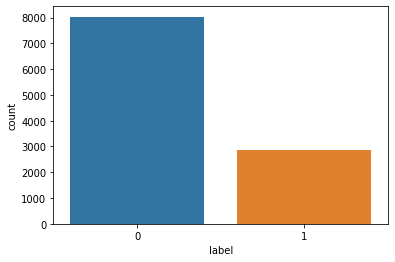

In [3]:
sns.countplot(x='label',data=df)
print(df.groupby('label').describe())

Since replied emails create many outliers (email text includes the text it was replying to), we want to look at both the length, and log length distributions of the emails 

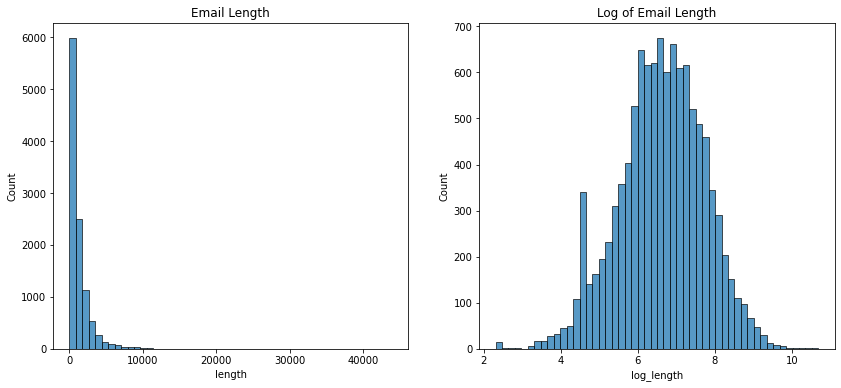

In [7]:
df['length'] = df['text'].apply(len)
df['log_length'] = df['length'].apply(np.log)
fig, axs = plt.subplots(1,2,figsize = (14,6))
sns.histplot(df['length'],bins = 50,ax = axs[0]).set(title='Email Length')
sns.histplot(df['log_length'],bins = 50,ax = axs[1]).set(title='Log of Email Length')
plt.show()

Next I want to compare the length of the spam emails compared to regular emails to see if it may be an informative feature

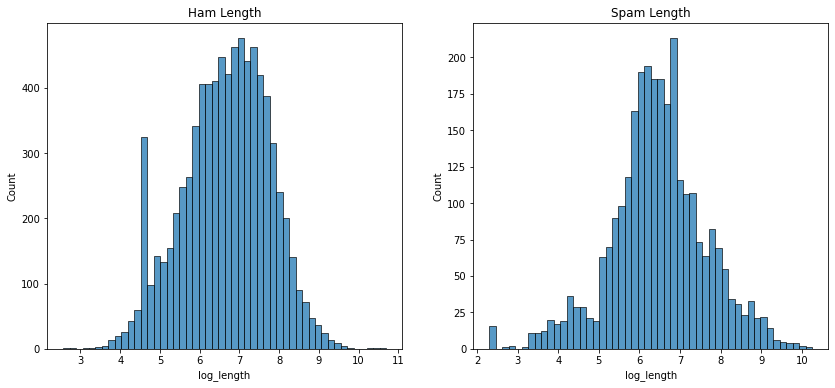

In [8]:
df_spam = df.loc[df['label']==1]
df_ham = df.loc[df['label']==0]
fig, axs = plt.subplots(1,2,figsize = (14,6))
sns.histplot(df_ham['log_length'],bins = 50,ax = axs[0]).set(title='Ham Length')
sns.histplot(df_spam['log_length'],bins = 50,ax = axs[1]).set(title='Spam Length')
plt.show()

Since the log spam length and ham length both appear to have a normal distribution, given that Ham has roughly 3x the entries, this shows us that they do not appear to systematically differ, there is evidence of some clumping for ham emails around 4.5 and spam emails around 2.3, however this may be due to peculiarities of the dataset such as duplicates or short follow-up response to a specific email.

### 1.2 Data Preprocessing

To get an idea of my nexts steps I check what an entry looks like

In [9]:
print(df['text'][0])

Subject: ena sales on hpl
 just to update you on this project ' s status :
 based on a new report that scott mills ran for me from sitara , i have come up
 with the following counterparties as the ones to which ena is selling gas off
 of hpl ' s pipe .
 altrade transaction , l . l . c . gulf gas utilities company
 brazoria , city of panther pipeline , inc .
 central illinois light company praxair , inc .
 central power and light company reliant energy - entex
 ces - equistar chemicals , lp reliant energy - hl & p
 corpus christi gas marketing , lp southern union company
 d & h gas company , inc . texas utilities fuel company
 duke energy field services , inc . txu gas distribution
 entex gas marketing company union carbide corporation
 equistar chemicals , lp unit gas transmission company inc .
 since i ' m not sure exactly what gets entered into sitara , pat clynes
 suggested that i check with daren farmer to make sure that i ' m not missing
 something ( which i did below ) . while i 



Below I pre-process the text which consists of 4 parts
<ul>
    <li>Clean: Remove punctuation, whitespaces, and convert all characters to lowercase
    <li>Tokenize: Break the text down into individual words
    <li>Remove Stopwards: Delete words that do not add information
    <li>Lemmatize: Convert words to their root words

In [10]:
import string
import re
wnl = nltk.WordNetLemmatizer()

#removes numbers from a string
def remove_numbers(text):
    result = re.sub(r'\d+','',text)
    return result

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=stopwords.union(set(string.punctuation))
#text_prep removes uninformative words, removes numbers, tokenizes and lemmatizes the input text
def text_prep(text):
    text = text.lower()
    text = remove_numbers(text)
    tokens = [token for token in nltk.word_tokenize(text)]
    tokens = [token for token in tokens if not token in stopwords]
    tokens = [wnl.lemmatize(token) for token in tokens]

    return(tokens)

In [11]:
text_data = [text_prep(txt) for txt in df['text']]
ham_text = [text_prep(txt) for txt in df.loc[df['label']==0]['text']]
spam_text = [text_prep(txt) for txt in df.loc[df['label']==1]['text']]

### 1.3 Additional Analysis

To understand which features may be important I create a graph of the most common words conditional on the type of email. This can show the overlap of common words that possibly contain no information, as well as the potential for some words to be a strong indicator of spam vs. ham, at least when using a "bag of words" method such as the Naive Bayes classifier.

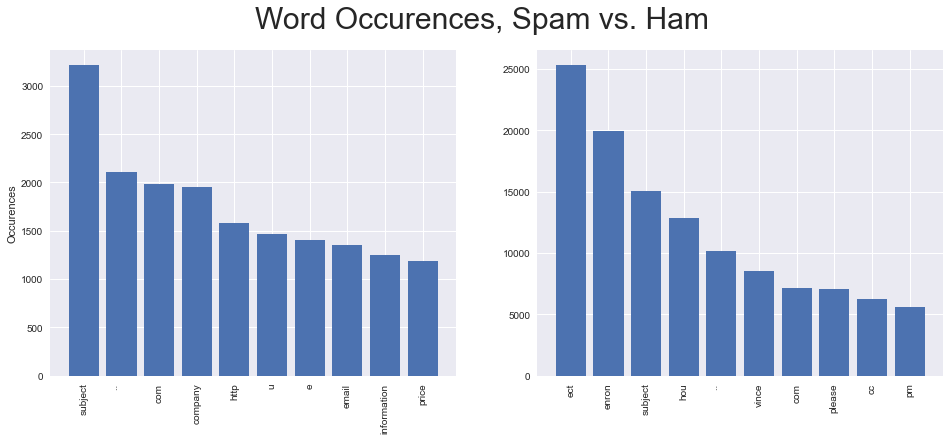

In [13]:
spam_wf = nltk.FreqDist([word for doc in spam_text for word in doc]).most_common(10)
spam_words = [x[0] for x in spam_wf]
spam_cnt = [x[1] for x in spam_wf]
ham_wf = nltk.FreqDist([word for doc in ham_text for word in doc]).most_common(10)
ham_words = [x[0] for x in ham_wf]
ham_cnt = [x[1] for x in ham_wf]

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(range(len(spam_words)), spam_cnt);
ax[0].set_xticks(range(len(spam_words)));
ax[0].set_xticklabels(spam_words, rotation='vertical');
ax[0].set_ylabel('Occurences');
ax[1].bar(range(len(ham_words)), ham_cnt);
ax[1].set_xticks(range(len(ham_words)));
ax[1].set_xticklabels(ham_words, rotation='vertical');
fig.suptitle('Word Occurences, Spam vs. Ham',size=30)
plt.show()

## Classification
In this section I imitate the methods used in class and provide my own analysis and interpretation of the results, as well as tweaking the methods for my specific dataset

### 2.1 Feature Engineering
I use the sklearn package to select features for x, and create a list of corresponding outputs for y

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.7)
y = [l for l in df['label']]
X = vectorizer.fit_transform([' '.join(doc) for doc in text_data])

Next I split the data into training and testing sets

In [15]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

### 2.2 Naive Bayes

Next I train the Multinomial Naive Bayes Classifier, searching for the optimal paramater <em> alpha</em> and return it's accuracy. This method will only take into account the words used and not their grammatical form or order, therefore if the structure of spam emails is irregular this model will not be optimal. <br/><br/> The grid searching method is inspired by the post: https://www.kaggle.com/code/itratrahman/nlp-tutorial-using-python/notebook

Best parameter:  {'alpha': 61.19597989949749}
Best score:  -0.20066490920131966


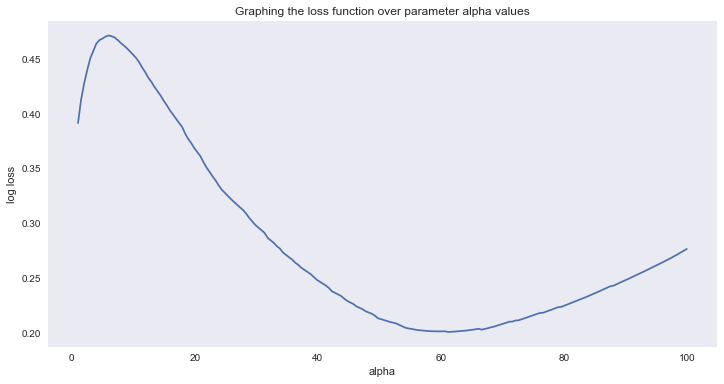

In [21]:
from sklearn import naive_bayes
from sklearn.model_selection import GridSearchCV
#defining the classifier
MNB_classifier = naive_bayes.MultinomialNB()
#searching the grid using 5-fold validation
alpha_list = np.linspace(1, 100, 200)
parameter_grid = [{"alpha":alpha_list}]
gridsearch_NB = GridSearchCV(MNB_classifier,parameter_grid, scoring = 'neg_log_loss', cv = 5)
gridsearch_NB.fit(Xtrain, ytrain)
results = pd.DataFrame()
#storing the parameter values
results['alpha'] = gridsearch_NB.cv_results_['param_alpha'].data
results['neglogloss'] = gridsearch_NB.cv_results_['mean_test_score'].data

matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.plot(results['alpha'], -results['neglogloss'])
plt.title('Graphing the loss function over parameter alpha values')
plt.xlabel('alpha')
plt.ylabel('log loss')
plt.grid()
print("Best parameter: ",gridsearch_NB.best_params_)
print("Best score: ",gridsearch_NB.best_score_) 

Next I use the best parameter to evaluate the performance of the model

In [23]:
MNB_classifier = naive_bayes.MultinomialNB(alpha=61.306)
MNB_classifier.fit(Xtrain,ytrain)
print(f'The accuracy is {round(np.mean(MNB_classifier.predict(Xtest)==ytest)*100)}%')

The accuracy is 96%


To evaluate the model, we need to look at more metrics than it's pure accuracy. Below I show the confusion matrix.

In [24]:
from sklearn import metrics
print(metrics.confusion_matrix(ytest, MNB_classifier.predict(Xtest)))
print(metrics.classification_report(ytest, MNB_classifier.predict(Xtest)))

[[2343   30]
 [  98  795]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2373
           1       0.96      0.89      0.93       893

    accuracy                           0.96      3266
   macro avg       0.96      0.94      0.95      3266
weighted avg       0.96      0.96      0.96      3266



We see that the model is actually performing alright considering that it does not take into account that the grammar of the email may matter. The f1-scores appears promising for such a simple method.

### 2.3 Logistic Regression
Utilizing logistic regression on the features, this method also does not take into account the order of words, however the model is designed to predict the probability an input is 0 or 1 making it a choice of classifier worth exploring. In this case the parameters are not particularly meaningful so I don't test alternative parameters.

In [25]:
from sklearn import linear_model
logistic_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_model.fit(Xtrain, ytrain)
print(f'The accuracy is {round(np.mean(logistic_model.predict(Xtest)==ytest)*100,2)}%')

The accuracy is 98.13%


In [26]:
print(metrics.confusion_matrix(ytest,logistic_model.predict(Xtest)))
print(metrics.classification_report(ytest, logistic_model.predict(Xtest)))

[[2338   35]
 [  26  867]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2373
           1       0.96      0.97      0.97       893

    accuracy                           0.98      3266
   macro avg       0.98      0.98      0.98      3266
weighted avg       0.98      0.98      0.98      3266



We find the the logistic model improves upon the Naive Bayes approach in terms of raw accuracy, it also improves in every aspect of the confusion, with both fewer false positives and false negatives.

### 2.4 Neural Networks
In this method, I employ an MLP strategy to classify the data. For tuning the parameters I took inspiriation from this post: https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-neural-network which walks through parameter searching and suggests parameters to try.

In [32]:
from sklearn.neural_network import MLPClassifier
MLP_classifier = MLPClassifier()

params = {'activation': ['relu', 'tanh', 'logistic', 'identity'],
          'hidden_layer_sizes': [(100,), (50,100,), (50,75,100,)],
          'solver': ['adam'],
          'learning_rate' : ['constant']
         }

gridsearch_MLP = GridSearchCV(MLPClassifier(random_state=0), param_grid=params, n_jobs=-1, cv=5, verbose=5,scoring = 'neg_log_loss')
gridsearch_MLP.fit(Xtrain,ytrain)
print("Best parameters: ",gridsearch_MLP.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameter:  {'activation': 'logistic', 'hidden_layer_sizes': (50, 75, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best score:  -0.07409855425518838


In [33]:
MLP_classifier = neural_network.MLPClassifier(**gridsearch_MLP.best_params_)
MLP_classifier.fit(Xtrain,ytrain)
print(f'The accuracy is {round(np.mean(MLP_classifier.predict(Xtest)==ytest)*100,2)}%')

The accuracy is 98.29%


In [34]:
print(metrics.confusion_matrix(ytest,MLP_classifier.predict(Xtest)))
print(metrics.classification_report(ytest, MLP_classifier.predict(Xtest)))

[[2343   30]
 [  26  867]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2373
           1       0.97      0.97      0.97       893

    accuracy                           0.98      3266
   macro avg       0.98      0.98      0.98      3266
weighted avg       0.98      0.98      0.98      3266



This model provides the best results by all metrics, of particular interest id the false positive metric, as users would prefer to tradeoff more false negatives in return for false postives as the cost of a small amount spam entering your regular inbox is much less impactful than missing a potentiall important business email. 

### 2.5 Conclusion
Comparing all the models fit, and considering that we would prefer models which have fewer false positives all else being equal, the logistic regression modeland neural network perform similarly. Depending on the circumstances I would consider them similarly equal, the neural network performs better, but is more computationally costly.

# 3. Unsupervised Topic Classification
In this section I utilize the methods overviewed in class similar to section 2, this time for unsupervised learning.

## 3.1 Latent Semantic Analysis
Following the examples from class, I use latent semantic analysis to detect similarities among ham vs. spam. I will use the term frequency and inverse-document-frequency-representation.<br/><br/>
This method does not contribute to the overall goal of detecting spam, but instead ranks topic similarity, which can improve understanding of the dataset.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in text_data])

Here use a principal component method to break down the variation of the dataset into the 10 multidimensional vectors which provide the most informative variation.

In [36]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=0)
svd_model.fit(X)

TruncatedSVD(n_components=10, n_iter=100, random_state=0)

Here we can see the first 10 columns of the reduced principal component matrix in a form that shows the corresponding variable (in this case a word).

In [37]:
print(svd_model.explained_variance_ratio_)
print(svd_model.explained_variance_ratio_.cumsum())
terms = tfidf_vectorizer.get_feature_names_out()
comp_label=[]
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    message = ""
    for t in sorted_terms:
        message = message + "{:.2f} * {} + ".format(t[1],t[0])
    print(message)
    comp_label.append(message)

[0.01476627 0.01697098 0.01111577 0.01167305 0.00896506 0.00594657
 0.00548184 0.00529264 0.00462671 0.00421889]
[0.01476627 0.03173725 0.04285302 0.05452607 0.06349112 0.06943769
 0.07491953 0.08021218 0.08483889 0.08905777]
Topic 0: 
0.59 * ect + 0.31 * hou + 0.31 * enron + 0.17 * vince + 0.15 * subject + 0.11 * cc + 0.11 * hpl + 
Topic 1: 
0.51 * xl + 0.42 * hpl + 0.28 * hplno + 0.23 * nom + 0.22 * file + 0.21 * hplo + 0.20 * attached + 
Topic 2: 
0.48 * ect + 0.25 * hou + 0.20 * xl + 0.12 * hplno + 0.09 * hplo + 0.09 * nom + 0.08 * file + 
Topic 3: 
0.38 * hpl + 0.33 * tap + 0.33 * teco + 0.32 * enron + 0.27 * actuals + 0.18 * iferc + 0.14 * lsk + 
Topic 4: 
0.47 * deal + 0.40 * meter + 0.19 * volume + 0.18 * gas + 0.17 * daren + 0.13 * mmbtu + 0.13 * flow + 
Topic 5: 
0.36 * tu + 0.25 * mmbtu + 0.21 * utility + 0.21 * texas + 0.20 * nomination + 0.18 * com + 0.18 * actual + 
Topic 6: 
0.22 * nomination + 0.17 * mmbtu + 0.16 * ect + 0.16 * calpine + 0.14 * gas + 0.14 * eastrans + 0

Now, we can visualize the components. Since 10-dimensional space is difficult to visualize, I employ t-SNE to reduce dimensionality while making clear the original clusters using a nearest neighbours technique.

In [44]:
lsa_topic_matrix = svd_model.transform(X)
from sklearn.manifold import TSNE
nplot = 2000 # reduce the size of the data to speed computation and make the plot less cluttered
lsa_topic_sample = lsa_topic_matrix[np.random.choice(lsa_topic_matrix.shape[0], nplot, replace=False)]
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=500,
                      n_iter=1000, verbose=10, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_sample)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.028336
[t-SNE] Computed conditional probabilities in 0.042s
[t-SNE] Iteration 50: error = 66.1965408, gradient norm = 0.2145483 (50 iterations in 0.290s)
[t-SNE] Iteration 100: error = 64.5424957, gradient norm = 0.2068159 (50 iterations in 0.363s)
[t-SNE] Iteration 150: error = 64.4649887, gradient norm = 0.2014885 (50 iterations in 0.330s)
[t-SNE] Iteration 200: error = 64.5604172, gradient norm = 0.2078629 (50 iterations in 0.332s)
[t-SNE] Iteration 250: error = 64.5440979, gradient norm = 0.2007949 (50 iterations in 0.338s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.544098
[t-SNE] Iteration 300: error = 0.8273140, gradient norm = 0.0007630 (50 iterations in 0.255s

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


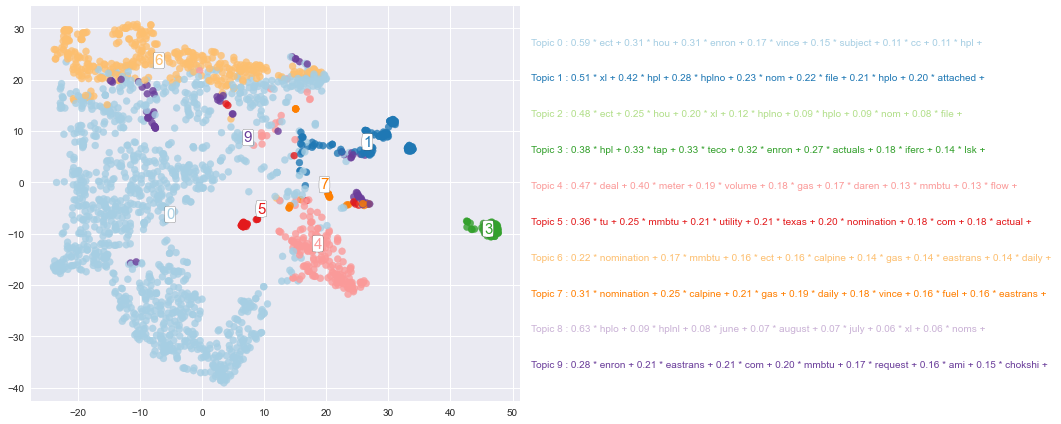

In [45]:
cmap = matplotlib.cm.get_cmap('Paired')
fig, ax = plt.subplots(1,2,figsize=(16,6))
n_topics=len(svd_model.components_)
lsa_keys = np.argmax(lsa_topic_sample, axis=1)
ax[0].scatter(x=tsne_lsa_vectors[:,0],y=tsne_lsa_vectors[:,1], color=[cmap(i) for i in lsa_keys], alpha=0.8)
bbox_props = dict(boxstyle="round4,pad=0.1", lw=0.2, fc="white")
for i in range(n_topics):
    m = tsne_lsa_vectors[lsa_keys==i, :].mean(axis=0)
    ax[0].text(m[0], m[1], str(i), ha="center", va="center",
               size=15, color=cmap(i),
               bbox=bbox_props)
    ax[1].text(0,1-(i+1)*1/(n_topics+1),"Topic " + str(i) + " : "+ comp_label[i],ha="left", va="center", color=cmap(i))
    ax[1].axis('off')
fig.tight_layout()

This shows us that most emails are related to topic 6 or topic 0, and that topic 0 encapsulates a large amount of space. Topics 1 and especially 3 appear very distinct.

## 3.2 Latent Dirichlet Analysis

LDA produces similar outputs to Latent Semantic analysis, but accounts for words being discrete.

In [40]:
import gensim
#convert text_data to a bag of words
dictionary = gensim.corpora.Dictionary(text_data)
bow_data = [dictionary.doc2bow(text) for text in text_data]

In [41]:
ldamodel = gensim.models.ldamodel.LdaModel(bow_data, num_topics = 5, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

[CV 2/5] END activation=relu, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam;, score=-0.129 total time=   6.6s
[CV 5/5] END activation=relu, hidden_layer_sizes=(50, 75, 100), learning_rate=constant, solver=adam;, score=-0.190 total time=   5.2s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.098 total time=  16.7s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.086 total time=  26.3s
[CV 5/5] END activation=identity, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.197 total time=  16.4s
[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam;, score=-0.192 total time=   7.2s
[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 75, 100), learning_rate=constant, solver=adam;, score=-0.149 total time=   6.2s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, so

[CV 3/5] END activation=relu, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam;, score=-0.124 total time=   6.2s
[CV 1/5] END activation=relu, hidden_layer_sizes=(50, 75, 100), learning_rate=constant, solver=adam;, score=-0.187 total time=   5.4s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.128 total time=  16.3s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.112 total time=  25.2s
[CV 1/5] END activation=identity, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.180 total time=  16.8s
[CV 1/5] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam;, score=-0.180 total time=  16.7s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam;, score=-0.098 total time=   7.3s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(50, 75, 100), learning_rate=constant, so

In [46]:
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
#To ignore imp phase out depreciation warnings
warnings.filterwarnings("ignore") 
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, bow_data, dictionary)
lda_display

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/distutils/ccompiler.py:17: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  from distutils.sysconfig import customize_compiler


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.062340 -0.093027       1        1  34.837240
4      0.009106 -0.231345       2        1  26.696154
0     -0.166137  0.182630       3        1  15.786856
3     -0.098629  0.044224       4        1  12.663669
1      0.318000  0.097518       5        1  10.016081, topic_info=          Term          Freq         Total Category  logprob  loglift
41         ect  23425.000000  23425.000000  Default  30.0000  30.0000
67         hou  12004.000000  12004.000000  Default  29.0000  29.0000
197      enron  17808.000000  17808.000000  Default  28.0000  28.0000
34        deal   3659.000000   3659.000000  Default  27.0000  27.0000
130    subject  17729.000000  17729.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
665          u    450.055903   3832.627107   Topic5  -5.6728   0.1590
1109         g    299.223414    805.985856   Topic5  -6.0810   1.3101
222    message    383.699593   3039.612573   Topic5  -5.8323   0.2314
307      price    334.978784   3137.570289   Topic5  -5.9681   0.0638
2735  software    289.931109   1201.396696   Topic5  -6.1125   0.8794

[402 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
1178       1  0.073960     
1178       2  0.917422     
1178       4  0.007868     
535        1  0.584199    ``
535        2  0.243800    ``
...      ...       ...   ...
28887      5  0.984953    xp
527        1  0.340289  year
527        2  0.555479  year
527        3  0.094758  year
527        4  0.009336  year

[786 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])